In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm
from cv2 import cv2

In [4]:
numx = 30
numy = 60
x0 = numx // 2
y0 = numy // 2
t0 = 0

## Green's function (before optimizing)

$G(\rho, t) = \Theta (t - \frac{\rho}{v}) (1 - e^{-\frac{t-\rho/v}{\tau_\text{inc}}}) e^{-\frac{t-\rho/v}{\tau_\text{dec}}} e^{-\frac{\rho}{\rho_c}}$

In [171]:
def greens_function_slow(x, y, t, x0, y0, t0, tau_inc=5, tau_dec=10, rho_e=10, v=0.5):
    
    t = t - t0
    c_x = 20
    c_y = 1
    rho = np.sqrt(c_x * (x - x0) ** 2 + c_y * (y - y0) ** 2)
    if t <= rho / v:
        return 0
    else:
        return (1 - np.exp(-(t - rho / v) / tau_inc)) * np.exp(-(t - rho / v) / tau_dec) * np.exp(-rho / rho_e)

In [172]:
dt = 1
dx = 1
dy = 1

trange = np.arange(0, 100, dt)
xrange = np.arange(0, numx, dx)
yrange = np.arange(0, numy, dy)

data_mat = np.zeros((len(trange), len(xrange), len(yrange)))
for k, t in tqdm(enumerate(trange)):
    for i, x in enumerate(xrange):
        for j, y in enumerate(yrange):
            data_mat[k, i, j] = greens_function_slow(x, y, t, x0, y0, t0)

100it [00:01, 69.48it/s]


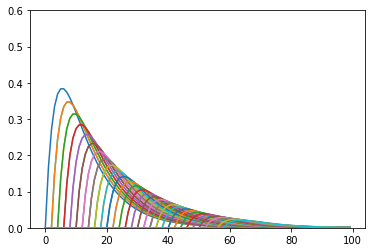

In [173]:
plt.figure()
plt.plot(data_mat[:, numx // 2, :])
plt.ylim(0, 0.6)
plt.show()